In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import openml as oml
%matplotlib inline

In [2]:
from IPython.display import Markdown, display
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from time import time

In [3]:
sb.set(font_scale=2)
sb.set_style('white')

## 3. Understanding Ensembles (5 points (3+2))
Do a deeper analysis of how RandomForests and Gradient Boosting reduce their prediction error. We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). When high-energy particles hit the atmosphere, they produce chain reactions of other particles called 'showers', and you need to detect whether these are caused by gamma rays or cosmic rays.

In [4]:
magic_data = oml.datasets.get_dataset(1120) # Download MAGIC Telescope data
X, y, attribute_names = magic_data.get_data(target=magic_data.default_target_attribute, return_attribute_names=True)
magic = pd.DataFrame(X, columns=attribute_names)

In [5]:
display(Markdown(magic_data.description))

**Author**: R. K. Bock. Major Atmospheric Gamma Imaging Cherenkov Telescope project (MAGIC)  
Donated by P. Savicky, Institute of Computer Science, AS of CR, Czech Republic  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/magic+gamma+telescope)  
**Please cite**: Bock, R.K., Chilingarian, A., Gaug, M., Hakl, F., Hengstebeck, T., Jirina, M., Klaschka, J., Kotrc, E., Savicky, P., Towers, S., Vaicilius, A., Wittek W. (2004). 
Methods for multidimensional event classification: a case study using images from a Cherenkov gamma-ray telescope. Nucl.Instr.Meth. A, 516, pp. 511-528.  

The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background). 

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions. 

The data set was generated by a Monte Carlo program, Corsika, described in: 
D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers, Forschungszentrum Karlsruhe FZKA 6019 (1998).
The program was run with parameters allowing to observe events with energies down to below 50 GeV.

Attribute Information:

1. fLength: continuous # major axis of ellipse [mm] 
2. fWidth: continuous # minor axis of ellipse [mm] 
3. fSize: continuous # 10-log of sum of content of all pixels [in #phot] 
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio] 
5. fConc1: continuous # ratio of highest pixel over fSize [ratio] 
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm] 
7. fM3Long: continuous # 3rd root of third moment along major axis [mm] 
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm] 
9. fAlpha: continuous # angle of major axis with vector to origin [deg] 
10. fDist: continuous # distance from origin to center of ellipse [mm] 
11. class: g,h # gamma (signal), hadron (background) 

g = gamma (signal): 12332 
h = hadron (background): 6688 

For technical reasons, the number of h events is underestimated. In the real data, the h class represents the majority of the events. 

The simple classification accuracy is not meaningful for this data, since classifying a background event as signal is worse than classifying a signal event as background. For comparison of different classifiers an ROC curve has to be used. The relevant points on this curve are those, where the probability of accepting a background event as signal is below one of the following thresholds: 0.01, 0.02, 0.05, 0.1, 0.2 depending on the required quality of the sample of the accepted events for different experiments.

In [6]:
display(magic_data.features)

{0: [0 - ID (numeric)],
 1: [1 - fLength: (numeric)],
 2: [2 - fWidth: (numeric)],
 3: [3 - fSize: (numeric)],
 4: [4 - fConc: (numeric)],
 5: [5 - fConc1: (numeric)],
 6: [6 - fAsym: (numeric)],
 7: [7 - fM3Long: (numeric)],
 8: [8 - fM3Trans: (numeric)],
 9: [9 - fAlpha: (numeric)],
 10: [10 - fDist: (numeric)],
 11: [11 - class: (nominal)]}

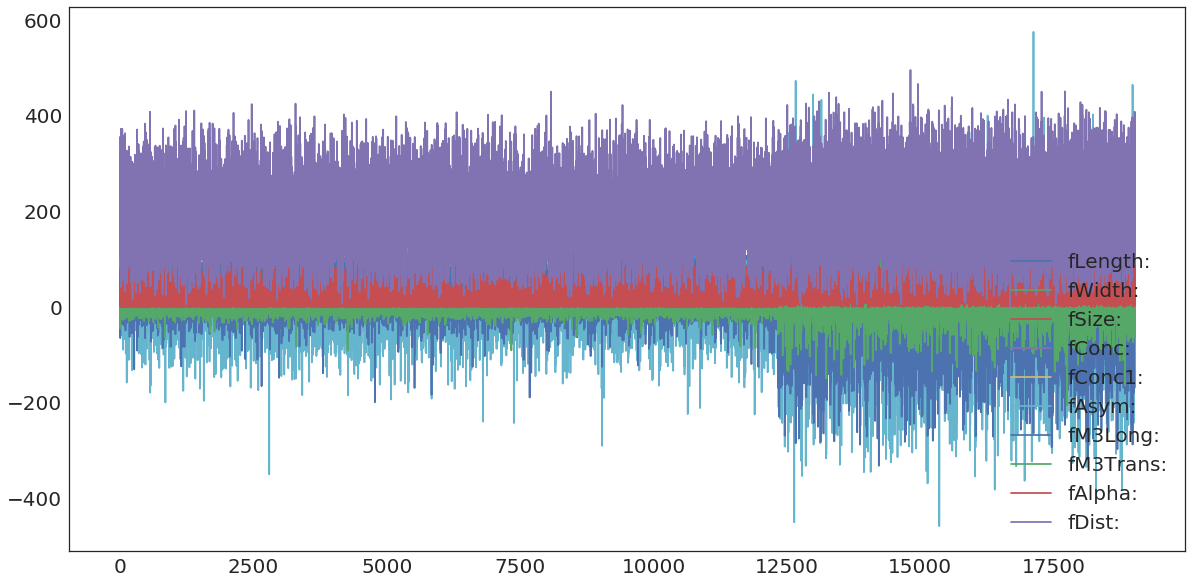

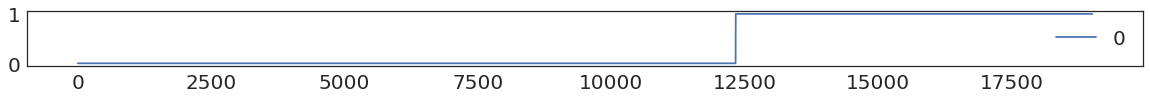

In [7]:
# Quick visualization
magic.plot(figsize=(20,10))
# Also plot the target: 1 = gamma, 0 = background
pd.DataFrame(y).plot(figsize=(20,1));

In [8]:
magic.head()

fLength:     fWidth:  fSize:  fConc:  fConc1:      fAsym:   fM3Long:  \
0   28.796700   16.002100  2.6449  0.3918   0.1982   27.700399  22.011000   
1   31.603600   11.723500  2.5185  0.5303   0.3773   26.272200  23.823799   
2  162.052002  136.031006  4.0612  0.0374   0.0187  116.740997 -64.858002   
3   23.817200    9.572800  2.3385  0.6147   0.3922   27.210699  -6.463300   
4   75.136200   30.920500  3.1611  0.3168   0.1832   -5.527700  28.552500   

   fM3Trans:    fAlpha:      fDist:  
0    -8.2027  40.091999   81.882797  
1    -9.9574   6.360900  205.261002  
2   -45.2160  76.959999  256.787994  
3    -7.1513  10.449000  116.737000  
4    21.8393   4.648000  356.462006

In [9]:
magic.describe()

fLength:       fWidth:        fSize:        fConc:       fConc1:  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean      53.250153     22.180967      2.825017      0.380327      0.214657   
std       42.364853     18.346056      0.472599      0.182813      0.110511   
min        4.283500      0.000000      1.941300      0.013100      0.000300   
25%       24.336000     11.863800      2.477100      0.235800      0.128475   
50%       37.147699     17.139900      2.739600      0.354150      0.196500   
75%       70.122175     24.739475      3.101600      0.503700      0.285225   
max      334.177002    256.381989      5.323300      0.893000      0.675200   

             fAsym:      fM3Long:     fM3Trans:       fAlpha:        fDist:  
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000  
mean      -4.331745     10.545545      0.249726     27.645704    193.818024  
std       59.206062     51.000118     20.827438     26.103621     74.731789  
min     -457.916107   -331.779999   -205.894699      0.000000      1.282600  
25%      -20.586551    -12.842775    -10.849375      5.547925    142.492252  
50%        4.013050     15.314100      0.666200     17.679500    191.851448  
75%       24.063699     35.837801     10.946425     45.883550    240.563820  
max      575.240723    238.320999    179.850998     90.000000    495.561005

## *The functions to be used is listed as follows*

In [10]:
# train and predict for one estimator with spedific hyper parameters
# the returned value is a list of all predictions for all data points
def sample_predictions_shuffle_split(estimator_constructor, X, y, n_iterations=100):
    y_all_pred = [[] for _ in range(len(y))]
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_iterations)
    
    for i, (train_ind, test_ind) in enumerate(shuffle_split.split(X)):
        #Train and predict
        est = estimator_constructor()
        est.fit(X[train_ind], y[train_ind])
        y_pred = est.predict(X[test_ind])
        #print("train size",len(train_ind), "test size", len(test_ind))
        #store predictions
        for i, ind in enumerate(test_ind):
            y_all_pred[ind].append(y_pred[i])
    return y_all_pred

In [11]:
# calculate the bias biases, variances, and errors
# note that the return value is the square of biases
def calculate_bv(y, y_all_pred, n_repeat):
    # Compute bias, variance, error
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat for i,x in enumerate(y_all_pred) if len(x)!=0])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat for i,x in enumerate(y_all_pred) if len(x)!=0])
    error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat for i,x in enumerate(y_all_pred) if len(x)!=0])
    return bias_sq, var, error

In [12]:
# do bias-variance analysis in batches based on tree_counts
def get_bv_analysis(estimator_constructor, X, y, tree_counts, n_splits=10, n_jobs=None):
    biases = []
    variances = []
    errors = []
    
    for tree_count in tqdm(tree_counts):
        if n_jobs:
            y_all_pred = sample_predictions_shuffle_split(lambda:estimator_constructor(n_estimators=tree_count, n_jobs=n_jobs), X, y, n_splits)
        else:
            y_all_pred = sample_predictions_shuffle_split(lambda:estimator_constructor(n_estimators=tree_count), X, y, n_splits)
            
        
        bias_sq, variance, error = calculate_bv(y, y_all_pred, n_splits)
        biases.append(bias_sq)
        variances.append(variance)
        errors.append(error)
    return biases, variances, errors

In [13]:
# visualize the results
def plot_bv_analysis(x_axis, biases_sq, variances, error, title=""):
    plt.figure(figsize=(8,6))
    plt.plot(x_axis, error, color="black", label="error", linewidth=3)
    plt.plot(x_axis, variances, color="cornflowerblue", label="variances", linewidth=2)
    plt.plot(x_axis, biases_sq, color="yellowgreen", label="biases_sq", linewidth=2)
    plt.xscale("log")
    plt.xlabel("Model Complexity")
    plt.ylabel("Error")
    plt.title("Biases-Variances Analysis --- {}".format(title))
    plt.legend()

1 . Do a bias-variance analysis of both algorithms. For each, vary the number of trees on a log scale from 1 to 1024, and plot the bias error (squared), variance, and total error (in one plot per algorithm). Interpret the results. Which error is highest for small ensembles, and which reduced most by each algorithm as you use a larger ensemble? When are both algorithms under- or overfitting? Provide a detailed explanation of why random forests and gradient boosting behave this way.
- See lecture 3 for an example on how to do the bias-variance decomposition
- To save time, you can use a 10% stratified subsample in your initial experiments, but show the plots for the full dataset in your report.

In [14]:
# initialize the tree counts
tree_counts = [2 ** x for x in range(0, 11)]
print("tree_counts = ", tree_counts)

tree_counts =  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


## Random Forest BV Analysis

In [15]:
t_start = time()
rf_biases_sq, rf_variances, rf_errors = get_bv_analysis(RandomForestClassifier, X, y, tree_counts,n_jobs=-1)
t_end = time()
print("the time it takes = {:.2f}s".format((t_end-t_start)))

100%|██████████| 11/11 [04:07<00:00, 22.46s/it]

the time it takes = 247.05s


In [16]:
print(rf_biases_sq)

[759.4791269841178, 803.7974999999902, 713.1774206349165, 686.8426984126966, 676.4549206349202, 675.2821825396808, 683.8049206349197, 681.8459523809499, 693.459285714282, 694.7600396825366, 701.4196428571412]


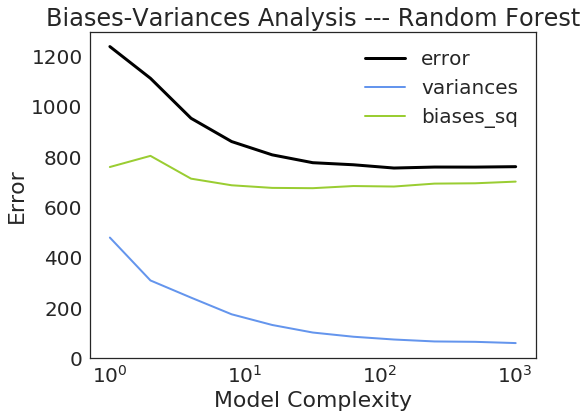

In [17]:
plot_bv_analysis(tree_counts, rf_biases_sq, rf_variances, rf_errors, title="Random Forest")

The graph above visualizes the BV analysis of the random forest model. The general trend of the volume of error with regard to the model complexity (represents the number of estimators in random forest) is as espected.
In order to show the bias, variance, and error in the same graph and still more or less on the same scale, the green line in the graph depicts the square of the bias.
### Variance
As the number of trees increase in random forest, the variance first drops really fast and then become more or less stable. Normally, as for non-ensenble machine learning models, we will expect the variance to increase as the model becomes more and more complicated. However, this is not the case for random forest.
One possible explanation is that each tree in random forest is built from a sample that is drawn with replacement from the dataset. Due to the voting mechanism, more bias voters will yield more stable results as the voting acts as a counter force for overfitting.
### Bias
While the general trend of the bias is as expected, it is worth noticing the fisrt increase and then drop phenomenon when the number of trees is relatively small. This could be possibly explained the fact that the sample that each tree 


In random forests (see RandomForestClassifier and RandomForestRegressor classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.


## Gradient Boosting BV Analysis

In [18]:
t_start = time()
gb_biases_sq, gb_variances, gb_errors = get_bv_analysis(GradientBoostingClassifier, X, y, tree_counts)
t_end = time()
print("the time it takes = {:.2f}s".format((t_end-t_start)))

100%|██████████| 11/11 [04:42<00:00, 25.72s/it]

the time it takes = 282.94s


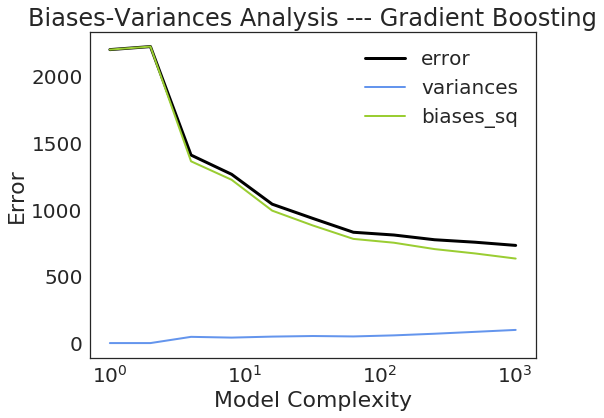

In [19]:
plot_bv_analysis(tree_counts, gb_biases_sq, gb_variances, gb_errors, title="Gradient Boosting")

In [20]:
print(rf_errors)
print(gb_errors)

[1238.4000000000278, 1112.200000000015, 953.3000000000168, 860.7000000000122, 807.8000000000055, 776.6000000000031, 768.4000000000043, 755.4000000000015, 759.2999999999996, 759.1000000000009, 760.8000000000026]
[2199.5000000000086, 2222.400000000023, 1409.0999999999929, 1264.9000000000003, 1041.0999999999963, 934.4999999999968, 830.5999999999981, 809.9000000000016, 774.5000000000019, 756.0000000000013, 732.0000000000024]


In [21]:
print(rf_biases_sq)
print(gb_biases_sq)

[759.4791269841178, 803.7974999999902, 713.1774206349165, 686.8426984126966, 676.4549206349202, 675.2821825396808, 683.8049206349197, 681.8459523809499, 693.459285714282, 694.7600396825366, 701.4196428571412]
[2199.5000000000086, 2222.400000000023, 1362.4349206349127, 1223.867420634917, 992.5907142857056, 881.6071428571349, 780.8795238095199, 752.120238095236, 704.4726190476166, 671.7954761904741, 633.3770634920629]


In [22]:
print(rf_variances)
print(gb_variances)

[478.92087301586605, 308.40249999999736, 240.12257936507882, 173.85730158730073, 131.3450793650789, 101.31781746031737, 84.59507936507937, 73.55404761904786, 65.8407142857145, 64.33996031746067, 59.38035714285736]
[0.0, 0.0, 46.66507936507951, 41.03257936507945, 48.50928571428588, 52.892857142857366, 49.720476190476376, 57.7797619047621, 70.02738095238117, 84.20452380952385, 98.62293650793637]


The graph above visualizes the BV analysis of the random forest model. The general trend of the volume of error with regard to the model complexity (represents the number of estimators in random forest) is as espected.
In order to show the bias, variance, and error in the same graph and still more or less on the same scale, the green line in the graph depicts the square of the bias.
### Bias and Variance
When the number of trees in the gradient boosting is relativley small, the model generate high bias compared to the random forest model. This could be explained by the essenses behind the two trees. Gradient boosting is based on weak learners and random forest on the other hand is based on fully developed decission tree. That is to say, a single tree in Gradient boosting has high bias and lower variance compared to its random forest counterparts. Thus, when the number of estimators is small, the gradient boosting model will have higher bias and lower variance compared to the random forest model. But as the number of trees increases in both model, the voting mechanism has shrink the gaps between the two models.
### Error
The errors of the two models converges approximately to similar value when the number of trees in each model is largely enough. However, when the number of trees is relatively small. Gradient Boosting have large errors which is mainly due to the high bias of the learners.

2 . A _validation curve_ can help you understand when a model starts under- or overfitting. It plots both training and test set error as you change certain characteristics of your model, e.g. one or more hyperparameters. Build validation curves for gradient boosting, evaluated using AUROC, by varying the number of iterations between 1 and 500. In addition, use at least two values for the learning rate (e.g. 0.1 and 1), and tree depth (e.g. 1 and 4). This will yield at least 4 curves. Interpret the results and provide a clear explanation for the results. When is the model over- or underfitting? Discuss the effect of the different combinations learning rate and tree depth and provide a clear explanation.
- While scikit-learn has a `validation_curve` function, we'll use a modified version (below) that provides a lot more detail and can be used to study more than one hyperparameter. You can use a default train-test split.

In [23]:
from sklearn.metrics import roc_auc_score

In [24]:
# Plots validation curves for every classifier in clfs. 
# Also indicates the optimal result by a vertical line
# Uses 1-AUROC, so lower is better
def validation_curve(clfs, X_test, y_test, X_train, y_train):
    for n,clf in enumerate(clfs):
        test_score = np.empty(len(clf.estimators_))
        train_score = np.empty(len(clf.estimators_))

        for i, pred in enumerate(clf.staged_decision_function(X_test)):
            test_score[i] = 1-roc_auc_score(y_test, pred)

        for i, pred in enumerate(clf.staged_decision_function(X_train)):
            train_score[i] = 1-roc_auc_score(y_train, pred)

        best_iter = np.argmin(test_score)
        learn = clf.get_params()['learning_rate']
        depth = clf.get_params()['max_depth']
        test_line = plt.plot(test_score,
                             label='learn=%.1f depth=%i (%.2f)'%(learn,depth,
                                                                 test_score[best_iter]))

        colour = test_line[-1].get_color()
        plt.plot(train_score, '--', color=colour)
        
        plt.xlabel("Number of boosting iterations")
        plt.ylabel("1 - area under ROC")
        plt.axvline(x=best_iter, color=colour)
        
    plt.legend(loc='best')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [26]:
clfs = (
    GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=1),
    GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=4),
    GradientBoostingClassifier(n_estimators=500, learning_rate=1, max_depth=1),
    GradientBoostingClassifier(n_estimators=500, learning_rate=1, max_depth=4),
)

for clf in clfs:
    clf.fit(X_train, y_train)


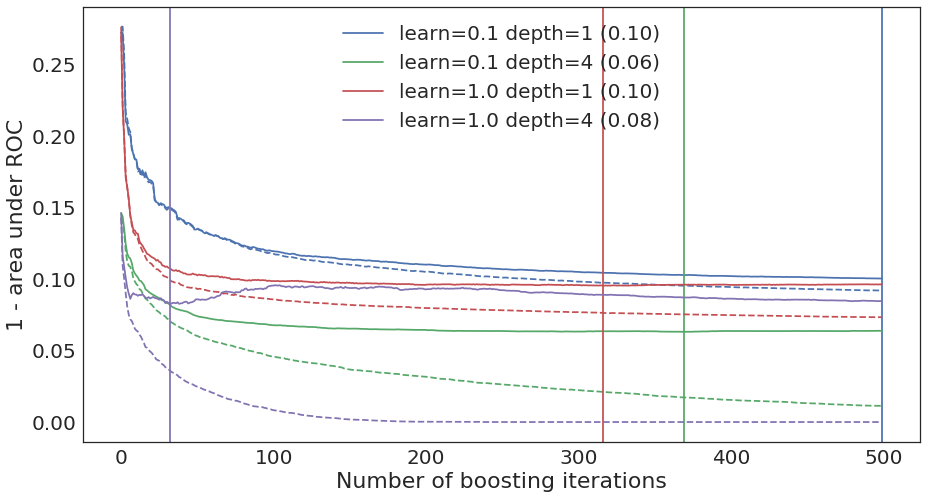

In [27]:
plt.figure(figsize=(15, 8))
validation_curve(clfs, X_test, y_test, X_train, y_train)

For set of parameters `learn=1 depth=4` we can see signs overfitting - training score improves, but test score doesn't improve very well, and even goes up at some point.

For sets of parameters `learn=0.1 depth=1` and `learn=1 depth=1` model underfits - both train and test scores go down, but they go down slowly and start to flat with numer of iterations increase.

Model with parameters `learn=0.1 depth=4` gives best test score among all other models.

These results can be explained in the following way.
- Underfitting for models `learn=0.1 depth=1` and `learn=1 depth=1` happens because of low complexity of base model (tree depth is only 1) and thus even putting these models in ensemble does not allow to improve trainig or test score significantly.

- Overfitting for model `learn=1 depth=4` happens becasuse parameter `learning_rate` controls contribution of each tree to final result. This in turn controls model overfitting (http://scikit-learn.org/stable/modules/ensemble.html#classification). Setting this parameter too high may leed to overfitting and thus low training error and poorly controllable test error.

- Model `learn=0.1 depth=4` had low enough learning rate and strong enough base estimatators to perform better than other models.